Tratamento dos dados e mesclagem dos datasets

Realizados: 
- Tratamento de respostas `7` e/ou `9` no PHQ-9
- Cálculo da coluna `phq9`
- Cálculo da coluna `phq_grp`
- Mesclagem dos datasets `DEMO_PHQ` e `PAG_HEI`

Outras possibilidades
- Tratamento da coluna `INDFMINC`

In [1]:
import numpy as np
import missingno as msno
import pandas as pd

# Oculta warnings do notebook
import warnings
warnings.filterwarnings('ignore')

# Configurações para facilitar a visualização dos dataframes
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Carregando dados demográficos e do PHQ
dataset_path = '../data/raw/'
demo_phq_dataset_name = 'DEMO_PHQ.csv'

demo_phq = pd.read_csv(f"{dataset_path}{demo_phq_dataset_name}", sep=',')

In [3]:
# Separando as colunas das respostas PHQ-9
is_phq_column = lambda x: True if (x.find('DPQ') > -1) else False
phq_cols = [col for col in demo_phq.columns if is_phq_column(col)]

In [4]:
# Checando ocorrencias de respostas 7 e 9 no PHQ-9
print(f'PHQ-9: Ocorrências de resposta 7: {(demo_phq[phq_cols] == 7.0).sum().sum()}')
print(f'PHQ-9: Ocorrências de resposta 9: {(demo_phq[phq_cols] == 9.0).sum().sum()}')

print(f'DEMO: Ocorrências de resposta 7 no DMDEDUC: {(demo_phq[["DMDEDUC"]] == 7.0).sum().sum()}')
print(f'DEMO: Ocorrências de resposta 9 no DMDEDUC: {(demo_phq[["DMDEDUC"]] == 9.0).sum().sum()}')

print(f'DEMO: Ocorrências de resposta 77 no INDFMINC: {(demo_phq[["INDFMINC"]] == 77.0).sum().sum()}')
print(f'DEMO: Ocorrências de resposta 99 no INDFMINC: {(demo_phq[["INDFMINC"]] == 99.0).sum().sum()}')

PHQ-9: Ocorrências de resposta 7: 0
PHQ-9: Ocorrências de resposta 9: 50
DEMO: Ocorrências de resposta 7 no DMDEDUC: 4
DEMO: Ocorrências de resposta 9 no DMDEDUC: 4
DEMO: Ocorrências de resposta 77 no INDFMINC: 36
DEMO: Ocorrências de resposta 99 no INDFMINC: 77


In [5]:
# Como estes valores significam uma ausencia de resposta, eles serão removidos para não influenciar nos cálculos
demo_phq[phq_cols] = demo_phq[phq_cols].replace([7.0, 9.0], np.nan)

demo_phq[["DMDEDUC"]] = demo_phq[["DMDEDUC"]].replace([7.0, 9.0], np.nan)
demo_phq[["INDFMINC"]] = demo_phq[["INDFMINC"]].replace([77.0, 99.0], np.nan)

In [6]:
# Calculando score do PHQ-9
demo_phq['PHQ9'] = demo_phq[phq_cols].sum(axis=1)

In [7]:
# Calculando grupo de sintomas de depressão
def get_phq9_group(score):
    if score < 5: return 0  # sem sintomas
    if score < 10: return 1  # sintomas leves
    if score < 15: return 2  # sintomas moderados
    if score < 19: return 3  # sintomas moderadamente severos
    return 4  # sintomas severos

demo_phq['PHQ_GRP'] = demo_phq['PHQ9'].map(get_phq9_group)

In [8]:
# Buscando linhas com todas colunas DPQ vazias
empty_dpq_rows = demo_phq.loc[:,"DPQ010":"DPQ090"].isna().all(1)
empty_dpq_rows = empty_dpq_rows[empty_dpq_rows == True].index

# Preenchando NaN nas colunas novas em linhas que não tiverem nenhuma resposta PHQ
demo_phq.loc[empty_dpq_rows, "PHQ9":"PHQ_GRP"] = np.nan

In [9]:
# Reordenando colunas para manter as colunas novas junto das respostas PHQ
demo_cols = ['RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDEDUC', 'INDFMINC']
phq_score_cols = ['PHQ9', 'PHQ_GRP']

ordered_columns = ["SEQN"] + phq_cols + phq_score_cols + demo_cols
demo_phq = demo_phq[ordered_columns]

<AxesSubplot: >

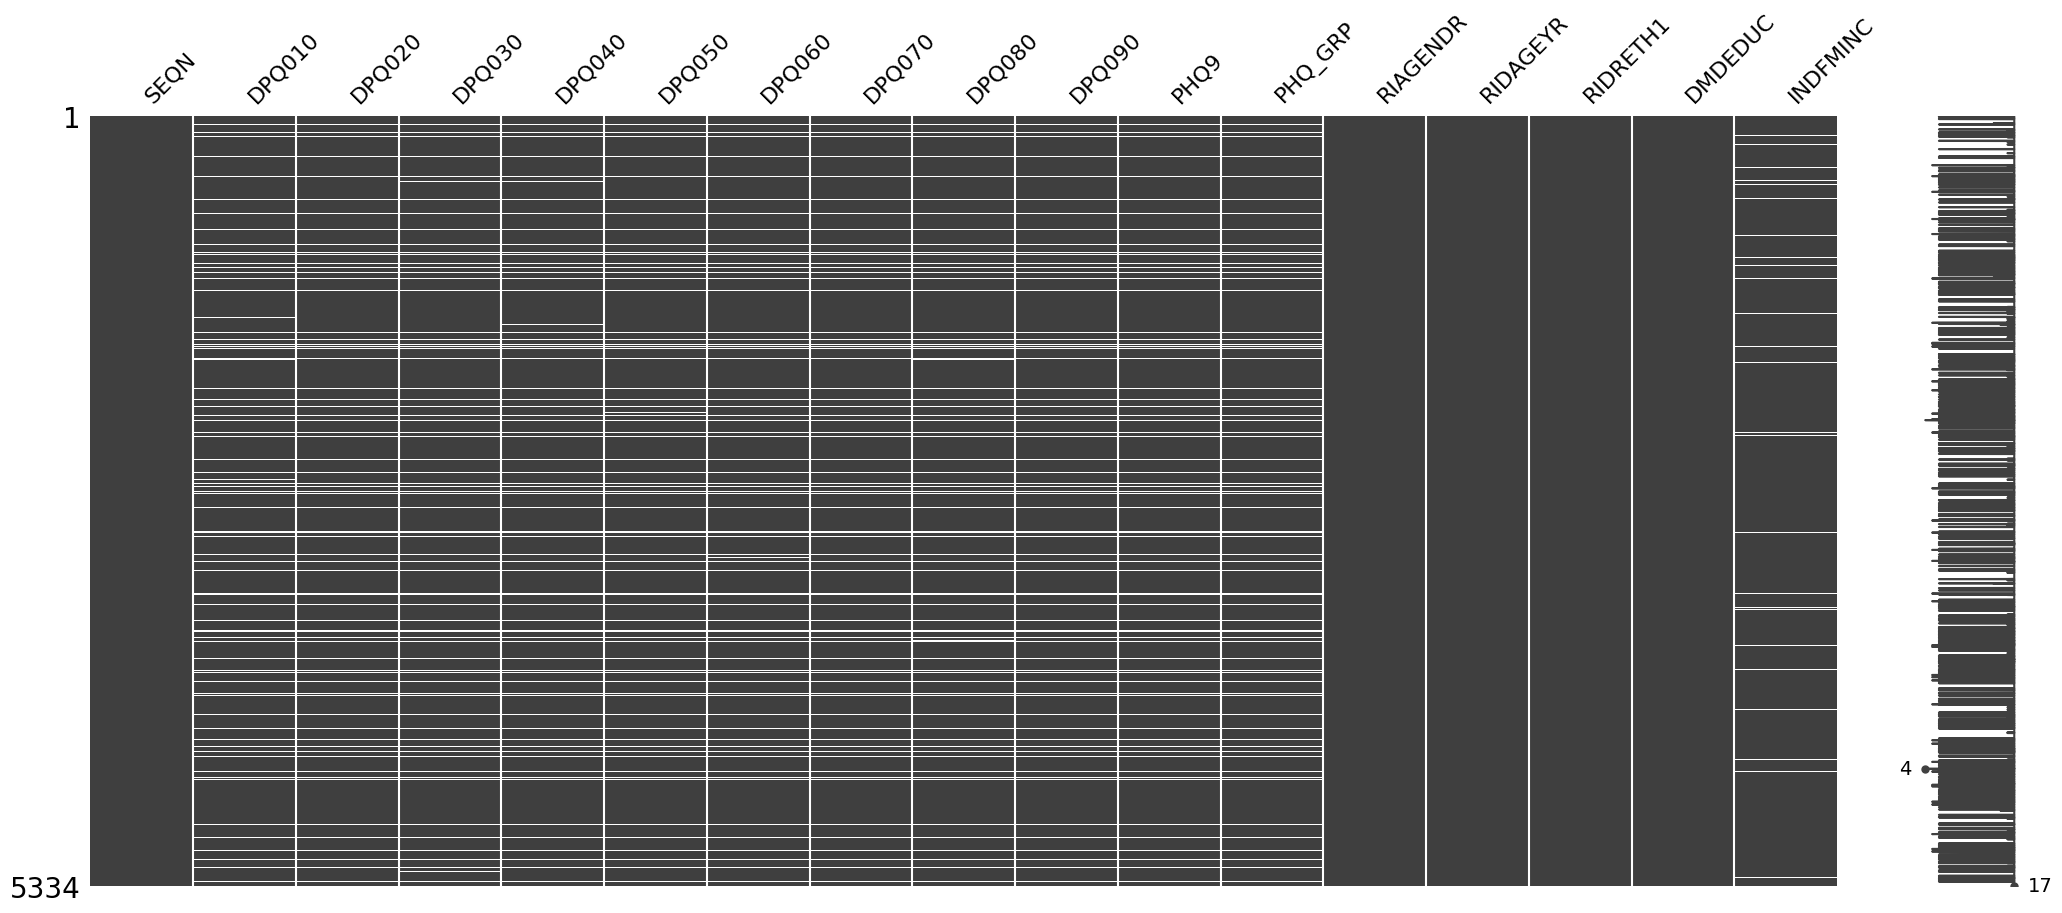

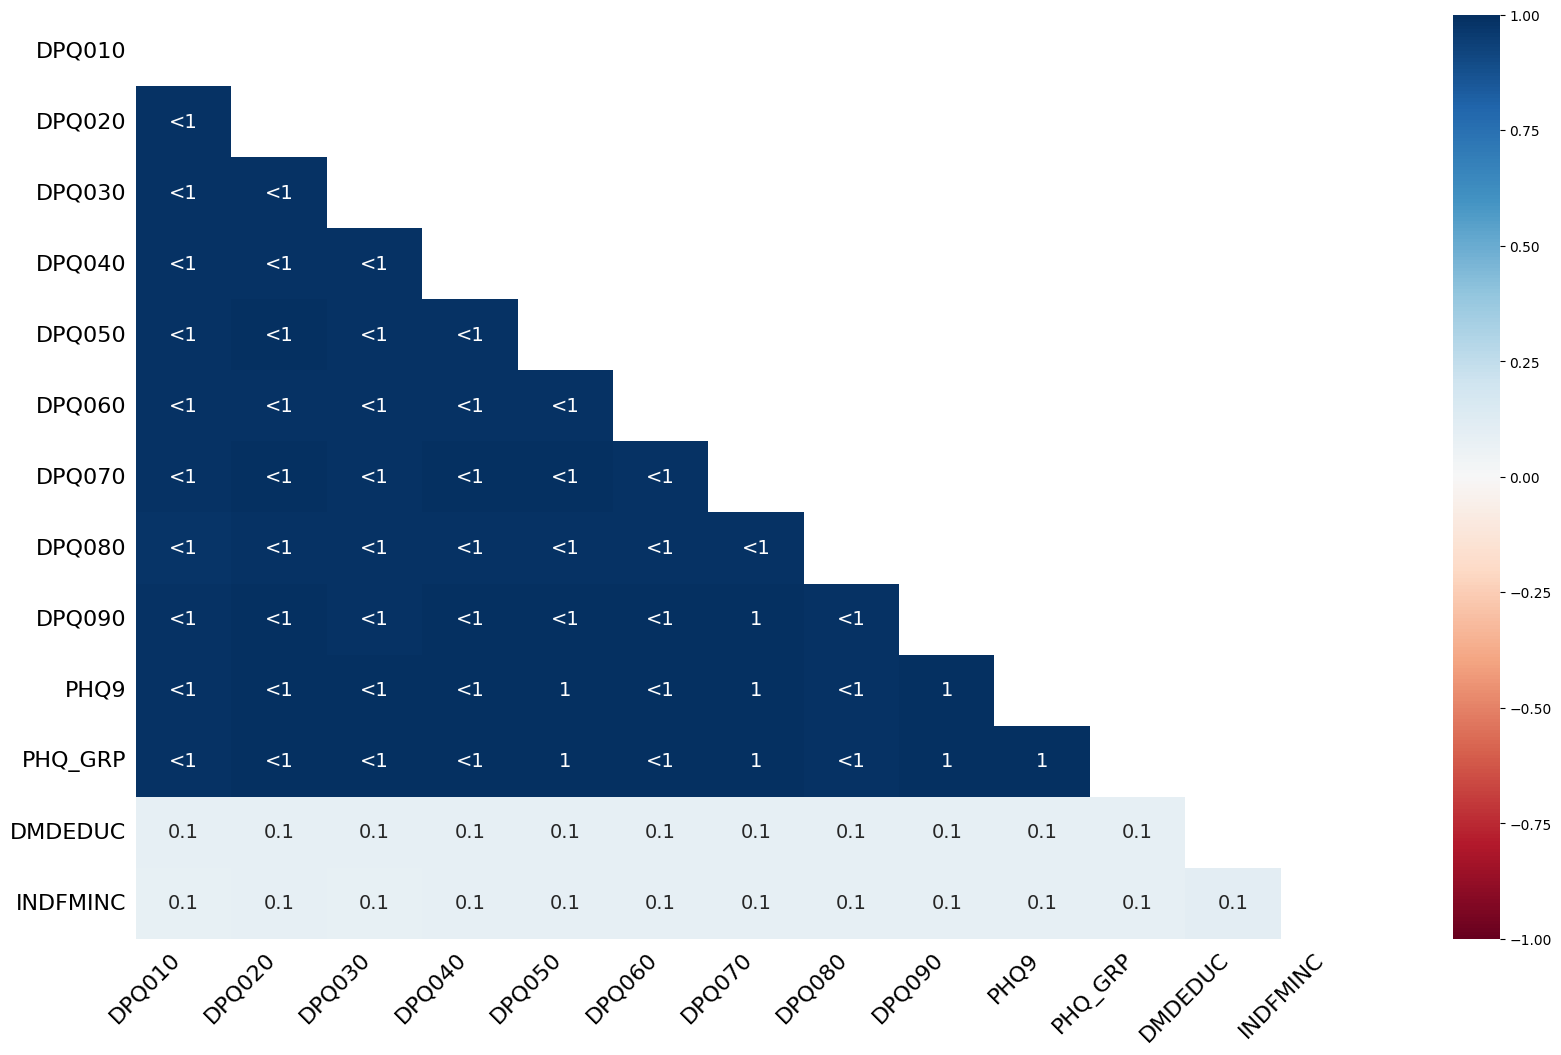

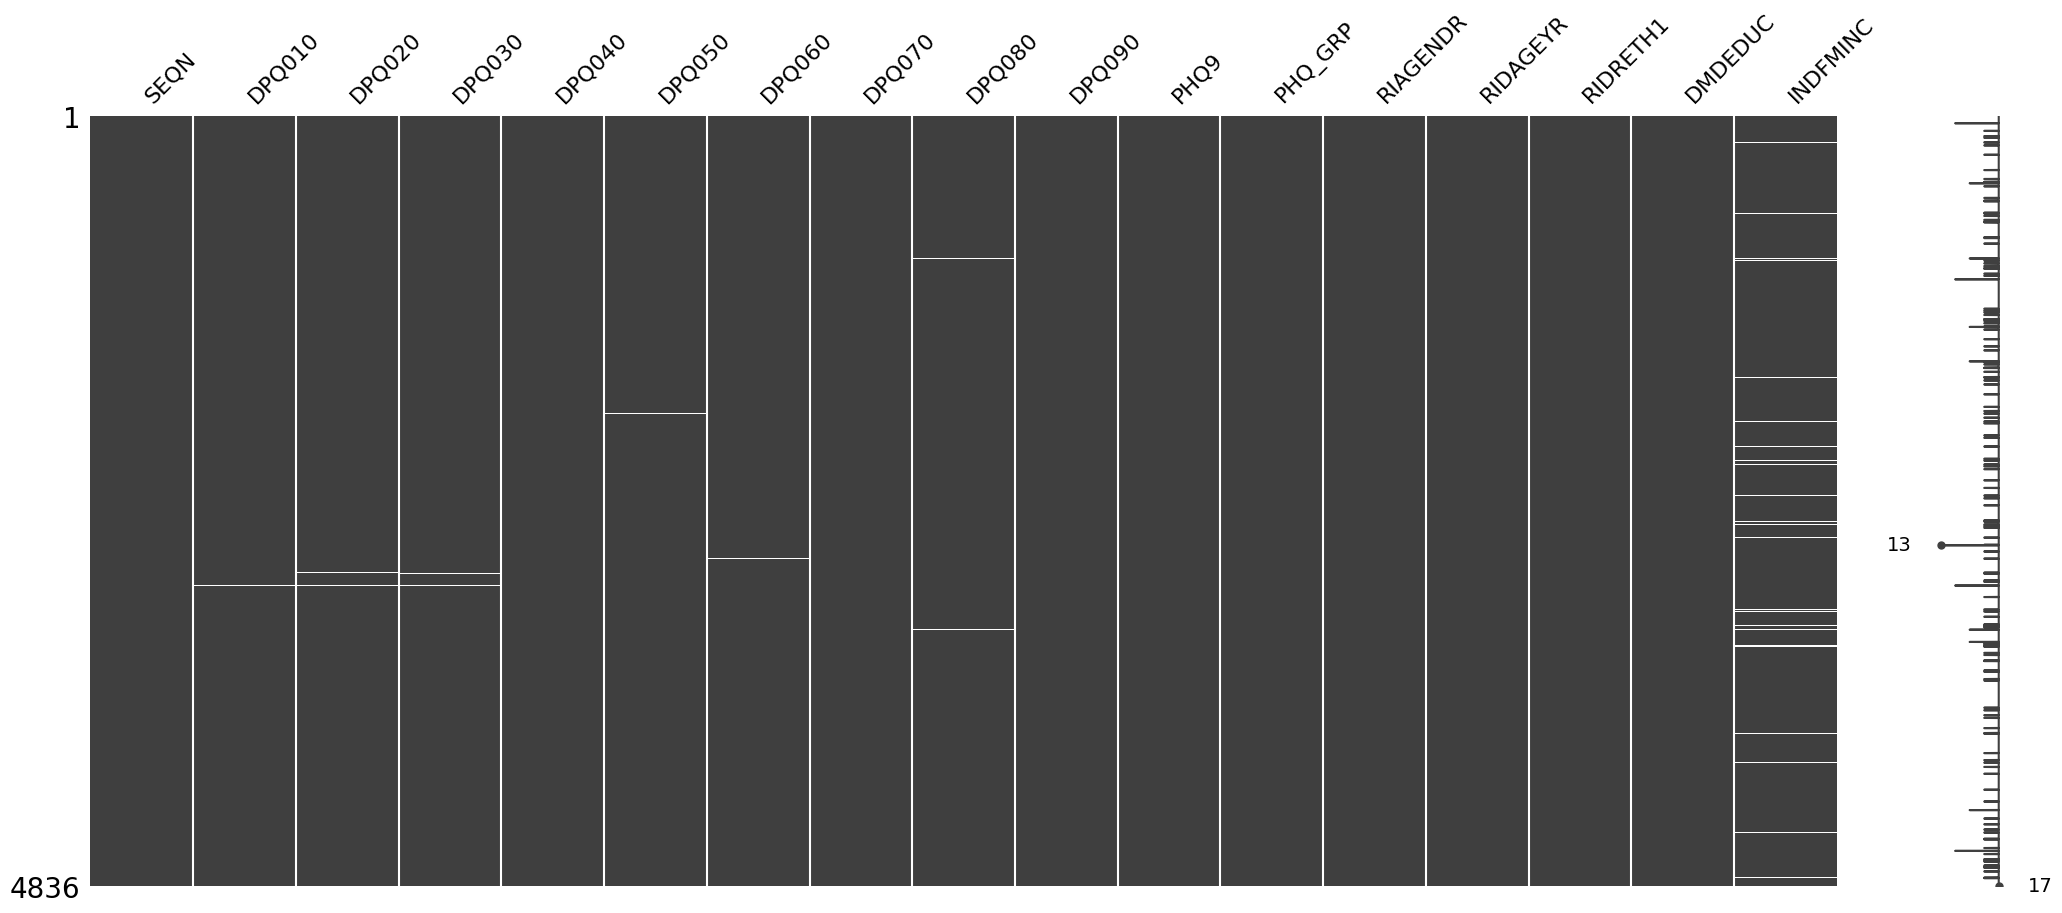

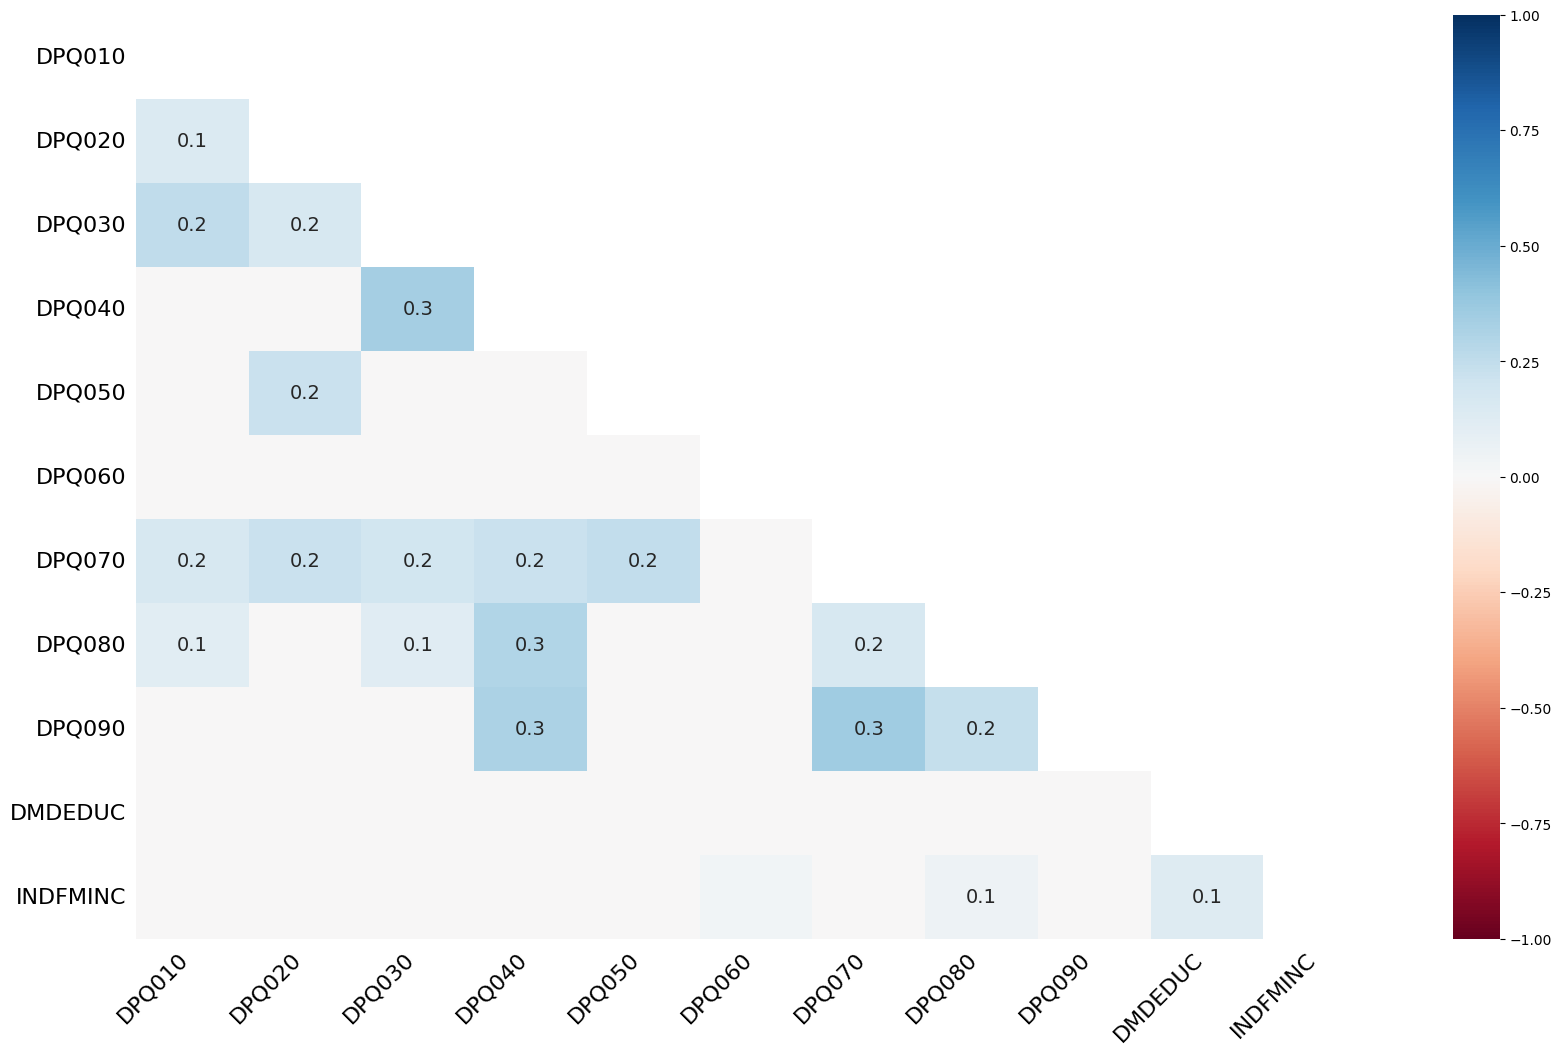

In [10]:
# Verificando ocorrência de valores ausentes
msno.matrix(demo_phq)
msno.heatmap(demo_phq)

# Verificando ocorrência de valores ausentes, desconsiderando os que não responderam nada do PHQ-9
msno.matrix(demo_phq[demo_phq.PHQ9.notna()])
msno.heatmap(demo_phq[demo_phq.PHQ9.notna()])

In [11]:
# Carregando dados do PAG e HEI
pag_hei_dataset_name = 'PAG_HEI.csv'
pag_hei = pd.read_csv(f"{dataset_path}{pag_hei_dataset_name}", sep=',')

In [12]:
# Mesclando dados de ambos datasets
df = pd.merge(demo_phq, pag_hei, on="SEQN", how="left")

# Checando dimensões após mesclagem
print("demo_phq:", demo_phq.shape)
print("pag_hei:", pag_hei.shape)
print("df mesclado:", df.shape)

demo_phq: (5334, 17)
pag_hei: (9424, 17)
df mesclado: (5334, 33)


In [13]:
# Exportando o dataframe mesclado
output_path = '../data/output/'
output_file = 'treated_dataset.csv'

df.to_csv(f"{output_path}{output_file}", sep=',', encoding='utf-8', index = False)